# Logistic Regression Project

### In this project we will be working with the UCI adult dataset. We will be attempting to predict if people in the data set belong in a certain class by salary, either making <=50k or >50k per year.

In [2]:
import math
import numpy as np
import pandas as pd
from datetime import datetime

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 
plt.style.use('seaborn-whitegrid')

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import statsmodels.api as sm

In [3]:
#Reading in the adult_sal.csv file and set it to a data frame called adult
adult = pd.read_csv('adult_sal.csv')
adult.drop(['Unnamed: 0'],axis=1,inplace=True)

In [4]:
#Checking the head of adult
adult.head()

,age,type_employer,fnlwgt,education,education_num,marital,occupation,relationship,race,sex,capital_gain,capital_loss,hr_per_week,country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [5]:
#Checking the summary of adult
adult.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
age              32561 non-null int64
type_employer    32561 non-null object
fnlwgt           32561 non-null int64
education        32561 non-null object
education_num    32561 non-null int64
marital          32561 non-null object
occupation       32561 non-null object
relationship     32561 non-null object
race             32561 non-null object
sex              32561 non-null object
capital_gain     32561 non-null int64
capital_loss     32561 non-null int64
hr_per_week      32561 non-null int64
country          32561 non-null object
income           32561 non-null object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


# Data Cleaning

In [6]:
#type_employer column
print(adult.groupby(['type_employer'], axis=0)['income'].count())

type_employer
?                    1836
Federal-gov           960
Local-gov            2093
Never-worked            7
Private             22696
Self-emp-inc         1116
Self-emp-not-inc     2541
State-gov            1298
Without-pay            14
Name: income, dtype: int64


In [7]:
#Combine these two smallest groups into a single group called "Unemployed"
#Combine State and Local gov jobs into a category called SL-gov 
#Combine self-employed jobs into a category called self-emp
def unemp (x):
    if (x=='Never-worked') | (x=='Without-pay'): return 'Unemployed'
    elif (x=='Local-gov') | (x=='State-gov'): return 'SL-gov'
    elif (x=='Self-emp-inc') | (x=='Self-emp-not-inc'): return 'self-emp'
    else: return x

adult['type_employer']=adult['type_employer'].apply(unemp)
print(adult.groupby(['type_employer'], axis=0)['income'].count())

type_employer
?               1836
Federal-gov      960
Private        22696
SL-gov          3391
Unemployed        21
self-emp        3657
Name: income, dtype: int64


In [8]:
#marital column
print(adult.groupby(['marital'], axis=0)['income'].count())

marital
Divorced                  4443
Married-AF-spouse           23
Married-civ-spouse       14976
Married-spouse-absent      418
Never-married            10683
Separated                 1025
Widowed                    993
Name: income, dtype: int64


In [9]:
#Reducing this to three groups: Married, Not-Married, and Never-Married
def mar_status (x):
    if (x=='Never-married'): return 'Never-married'
    elif (x=='Divorced') | (x=='Separated') | (x=='Widowed'): return 'Not-Married'
    else: return 'Married'

adult['marital']=adult['marital'].apply(mar_status)
print(adult.groupby(['marital'], axis=0)['income'].count())

marital
Married          15417
Never-married    10683
Not-Married       6461
Name: income, dtype: int64


In [10]:
#country column
print(adult.groupby(['country'], axis=0)['income'].count())

country
?                               583
Cambodia                         19
Canada                          121
China                            75
Columbia                         59
Cuba                             95
Dominican-Republic               70
Ecuador                          28
El-Salvador                     106
England                          90
France                           29
Germany                         137
Greece                           29
Guatemala                        64
Haiti                            44
Holand-Netherlands                1
Honduras                         13
Hong                             20
Hungary                          13
India                           100
Iran                             43
Ireland                          24
Italy                            73
Jamaica                          81
Japan                            62
Laos                             18
Mexico                          643
Nicaragua           

In [11]:
#Grouping these countries together
nam = ['Canada','United-States','Puerto-Rico']
eur = ['England' ,'France', 'Germany' ,'Greece','Holand-Netherlands','Hungary','Ireland','Italy','Poland','Portugal','Scotland','Yugoslavia']
asia = ['China','Hong','India','Iran','Cambodia','Japan', 'Laos' ,'Philippines' ,'Vietnam' ,'Taiwan', 'Thailand']
latam = ['Columbia','Cuba','Dominican-Republic','Ecuador','El-Salvador','Guatemala','Haiti','Honduras','Mexico','Nicaragua','Outlying-US(Guam-USVI-etc)','Peru','Jamaica','Trinadad&Tobago']
other = ['South']

In [12]:
def group_country (x):
    if x in nam: return 'nam'
    elif x in eur: return 'eur'
    elif x in asia: return 'asia'
    elif x in latam: return 'latam'
    else: return 'others'

adult['country']=adult['country'].apply(group_country)
print(adult.groupby(['country'], axis=0)['income'].count())

country
asia        671
eur         521
latam      1301
nam       29405
others      663
Name: income, dtype: int64


In [13]:
#Checking the head of adult
adult.head(10)

,age,type_employer,fnlwgt,education,education_num,marital,occupation,relationship,race,sex,capital_gain,capital_loss,hr_per_week,country,income
0,39,SL-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,nam,<=50K
1,50,self-emp,83311,Bachelors,13,Married,Exec-managerial,Husband,White,Male,0,0,13,nam,<=50K
2,38,Private,215646,HS-grad,9,Not-Married,Handlers-cleaners,Not-in-family,White,Male,0,0,40,nam,<=50K
3,53,Private,234721,11th,7,Married,Handlers-cleaners,Husband,Black,Male,0,0,40,nam,<=50K
4,28,Private,338409,Bachelors,13,Married,Prof-specialty,Wife,Black,Female,0,0,40,latam,<=50K
5,37,Private,284582,Masters,14,Married,Exec-managerial,Wife,White,Female,0,0,40,nam,<=50K
6,49,Private,160187,9th,5,Married,Other-service,Not-in-family,Black,Female,0,0,16,latam,<=50K
7,52,self-emp,209642,HS-grad,9,Married,Exec-managerial,Husband,White,Male,0,0,45,nam,>50K
8,31,Private,45781,Masters,14,Never-married,Prof-specialty,Not-in-family,White,Female,14084,0,50,nam,>50K
9,42,Private,159449,Bachelors,13,Married,Exec-managerial,Husband,White,Male,5178,0,40,nam,>50K


# Missing Data

In [14]:
#Converting any cell with a '?' or a ' ?' value to a missing value
adult.replace('?',np.NaN,inplace=True)
adult.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
age              32561 non-null int64
type_employer    30725 non-null object
fnlwgt           32561 non-null int64
education        32561 non-null object
education_num    32561 non-null int64
marital          32561 non-null object
occupation       30718 non-null object
relationship     32561 non-null object
race             32561 non-null object
sex              32561 non-null object
capital_gain     32561 non-null int64
capital_loss     32561 non-null int64
hr_per_week      32561 non-null int64
country          32561 non-null object
income           32561 non-null object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


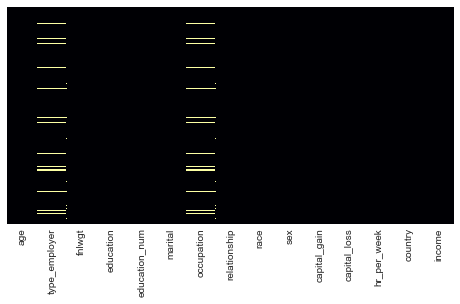

In [15]:
#Missing data heatmap
plt.figure(figsize=(8,4))
sns.heatmap(adult.isnull(),yticklabels=False,cbar=False,cmap='inferno')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30718 entries, 0 to 32560
Data columns (total 15 columns):
age              30718 non-null int64
type_employer    30718 non-null object
fnlwgt           30718 non-null int64
education        30718 non-null object
education_num    30718 non-null int64
marital          30718 non-null object
occupation       30718 non-null object
relationship     30718 non-null object
race             30718 non-null object
sex              30718 non-null object
capital_gain     30718 non-null int64
capital_loss     30718 non-null int64
hr_per_week      30718 non-null int64
country          30718 non-null object
income           30718 non-null object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


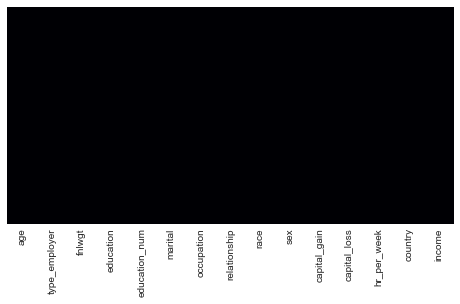

In [16]:
#Dropping missing data
adult.dropna(axis=0,inplace=True)
plt.figure(figsize=(8,4))
sns.heatmap(adult.isnull(),yticklabels=False,cbar=False,cmap='inferno')
adult.info()

# Exploratory Data Analysis

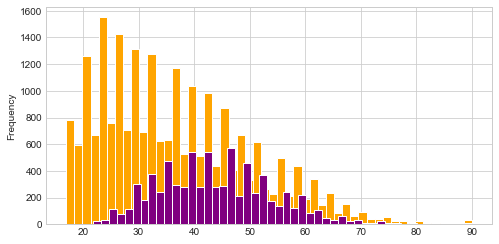

In [17]:
#histogram of age, colored by income
plt.figure(figsize=(8,4))
adult[adult['income']=='<=50K']['age'].plot.hist(bins=50,color='orange',edgecolor='white')
adult[adult['income']=='>50K']['age'].plot.hist(bins=50,color='purple',edgecolor='white')

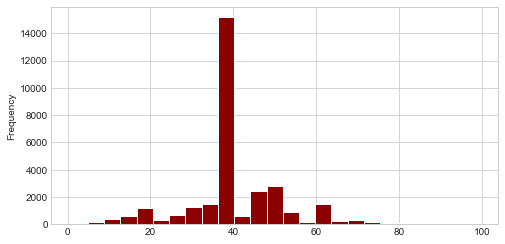

In [18]:
#Plotting a histogram of hours worked per week
plt.figure(figsize=(8,4))
adult['hr_per_week'].plot.hist(bins=25,color='darkred',edgecolor='white')

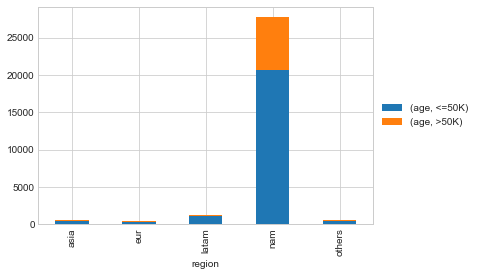

In [19]:
#Creating a barplot of region with the fill color defined by income class
adult.rename(columns={'country': 'region'}, inplace=True)

temp = adult.pivot_table(values=['age'], index=['region'], columns=['income'], aggfunc='count')
plt.figure(figsize=(8,4))
temp.plot(kind="bar",stacked=True)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

# Building the Model

In [20]:
#Getting the dummies
type_employer_Bin = pd.get_dummies(adult['type_employer'],drop_first=True,prefix='type_employer')
education_Bin = pd.get_dummies(adult['education'],drop_first=True,prefix='education')
marital_Bin = pd.get_dummies(adult['marital'],drop_first=True,prefix='marital')
occupation_Bin = pd.get_dummies(adult['occupation'],drop_first=True,prefix='occupation')
relationship_Bin = pd.get_dummies(adult['relationship'],drop_first=True,prefix='relationship')
region_Bin = pd.get_dummies(adult['region'],drop_first=True,prefix='region')
race_Bin = pd.get_dummies(adult['race'],drop_first=True,prefix='race')
sex_Bin = pd.get_dummies(adult['sex'],drop_first=True,prefix='sex')

income_Bin = pd.get_dummies(adult['income'],drop_first=True,prefix='income')

df = pd.concat([adult[['age','fnlwgt','capital_gain','capital_loss','hr_per_week']], type_employer_Bin,education_Bin,marital_Bin,occupation_Bin,relationship_Bin,region_Bin,race_Bin,sex_Bin,income_Bin],axis=1)

In [21]:
#Splitting the data into a train and test set 
x = df.drop('income_>50K',axis=1)
y = df['income_>50K']
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.3, random_state=101)

In [24]:
#Train and fit a logistic regression model on the training set.
x_train = sm.add_constant(x_train).copy()
logit = sm.Logit(y_train, x_train)
result = logit.fit()
result.summary()

         Current function value: inf
         Iterations: 35


C:\Users\rohit\Anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1214: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\rohit\Anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1264: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
C:\Users\rohit\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            income_>50K   No. Observations:                21502
Model:                          Logit   Df Residuals:                    21448
Method:                           MLE   Df Model:                           53
Date:                Fri, 27 Oct 2017   Pseudo R-squ.:                    -inf
Time:                        03:43:49   Log-Likelihood:                   -inf
converged:                      False   LL-Null:                   -4.5402e+06
                                        LLR p-value:                     1.000
================================================================================================
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const                           -5.6240      0.445    -12.648      0.000      -6.496      -4.752
age                              0.0277      0.002     13.838      0.000       0.024       0.032
fnlwgt                        7.882e-07   2.07e-07      3.804      0.000    3.82e-07    1.19e-06
capital_gain                     0.0003   1.28e-05     24.535      0.000       0.000       0.000
capital_loss                     0.0006   4.54e-05     13.532      0.000       0.001       0.001
hr_per_week                      0.0304      0.002     15.226      0.000       0.026       0.034
type_employer_Private           -0.5733      0.109     -5.241      0.000      -0.788      -0.359
type_employer_SL-gov            -0.7830      0.124     -6.326      0.000      -1.026      -0.540
type_employer_Unemployed       -21.4108   2.92e+04     -0.001      0.999   -5.72e+04    5.71e+04
type_employer_self-emp          -0.8948      0.122     -7.340      0.000      -1.134      -0.656
education_11th                  -0.0398      0.261     -0.153      0.879      -0.551       0.471
education_12th                   0.4387      0.328      1.339      0.181      -0.204       1.081
education_1st-4th               -0.5829      0.636     -0.916      0.359      -1.829       0.664
education_5th-6th               -0.4950      0.435     -1.137      0.255      -1.348       0.358
education_7th-8th               -0.5549      0.287     -1.936      0.053      -1.117       0.007
education_9th                   -0.1438      0.311     -0.462      0.644      -0.753       0.466
education_Assoc-acdm             1.2358      0.216      5.722      0.000       0.813       1.659
education_Assoc-voc              1.3284      0.208      6.387      0.000       0.921       1.736
education_Bachelors              1.8711      0.194      9.644      0.000       1.491       2.251
education_Doctorate              2.7977      0.263     10.650      0.000       2.283       3.313
education_HS-grad                0.7691      0.189      4.063      0.000       0.398       1.140
education_Masters                2.2381      0.207     10.832      0.000       1.833       2.643
education_Preschool            -22.3288   1952.688     -0.011      0.991   -3849.528    3804.870
education_Prof-school            2.7413      0.247     11.096      0.000       2.257       3.226
education_Some-college           1.1308      0.192      5.895      0.000       0.755       1.507
marital_Never-married           -1.0863      0.205     -5.311      0.000      -1.487      -0.685
marital_Not-Married             -0.5846      0.204     -2.867      0.004      -0.984      -0.185
occupation_Armed-Forces         -1.0312      1.635     -0.631      0.528      -4.235       2.172
occupation_Craft-repair          0.0788      0.095      0.831      0.406      -0.107       0.265
occupation_Exec-managerial       0.8930      0.092      9.743      0.000       0.713       1.073
occupation_Farming-fishing      -1.0462 

In [25]:
#Creating a confusion matrix
x_test = sm.add_constant(x_test).copy()
y_pred = result.predict(x_test)
test_calc = pd.concat([pd.DataFrame(y_test),pd.DataFrame(y_pred)],axis=1)
test_calc.rename(columns={0: 'predicted'}, inplace=True)

test_calc['predicted'] = test_calc['predicted'].apply(lambda x: 1 if x > 0.5 else 0)
df_table = confusion_matrix(test_calc['income_>50K'],test_calc['predicted'])
print (df_table)

[[6390  540]
 [ 901 1385]]


In [35]:
#Performance of the model
print('accuracy:', (df_table[0,0] + df_table[1,1]) / (df_table[0,0] + df_table[0,1] + df_table[1,0] + df_table[1,1]))
print ('precision:', df_table[1,1] / (df_table[1,1] + df_table[0,1]))
print('recall:', df_table[1,1] / (df_table[1,1] + df_table[1,0]))

p = df_table[1,1] / (df_table[1,1] + df_table[0,1])
r = df_table[1,1] / (df_table[1,1] + df_table[1,0])
print('f1 score: ', (2*p*r)/(p+r))

accuracy: 0.843641493056
precision: 0.719480519481
recall: 0.605861767279
f1 score:  0.657800997388


In [36]:
print (classification_report(test_calc['income_>50K'],test_calc['predicted']))

             precision    recall  f1-score   support

          0       0.88      0.92      0.90      6930
          1       0.72      0.61      0.66      2286

avg / total       0.84      0.84      0.84      9216

